In [1]:
#Dependencies
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt   
import cv2
from scipy.ndimage.filters import gaussian_filter

(257, 415)


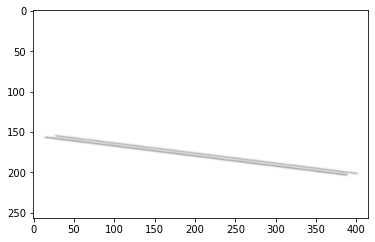

In [2]:
#load image and smooth it
img = cv2.imread("simulated_rails.png", cv2.IMREAD_GRAYSCALE)
img = gaussian_filter(img, sigma=0.8)
print(img.shape)
plt.imshow(img, cmap ="gray",vmin=0,vmax=255)
#img  = img[170:180,170:180]

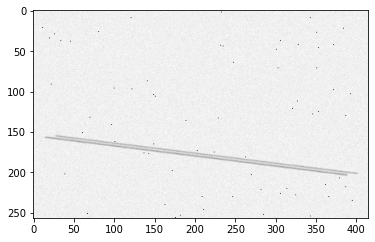

In [3]:
def addGaussianNoise(img, std, mean =0.0):
    img = np.clip(img, 3*std, 255-(3*std))#to not cut off noise
    img = (img + np.random.normal(mean, std, img.shape)).astype(np.uint8)
    img = np.clip(img, 0, 255)  # prevent getting out of bounds due to noise
    return img

img_noisy = addGaussianNoise(img, std= 5.0)    
plt.imshow(img_noisy, cmap ="gray",vmin=0,vmax=255)
    

differencde between images:
std: 7.821499411280843


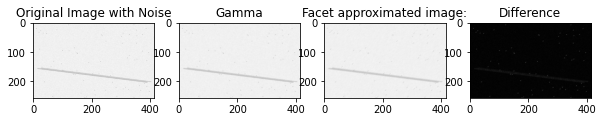

In [4]:
h_plane,w_plane = 3,3
delta_xi_min = - (h_plane // 2)  # -1
delta_xi_max = (h_plane // 2)  # 1 #EDIT
delta_yi_min = - (w_plane // 2)  # -1
delta_yi_max = (w_plane // 2)  # 1 #EDIT


def approximate_plane(img):
    """
    approximates gradient for  each position of an array by a plane. dimensions of the plane are given by
    self.h_plane, self.w_plane
    :param img: source image
    :return: alpha: array of slopes of planes in x-direction
    :return: beta: array of slopes of planes in y-direction
    """
    alpha = np.zeros(img.shape)
    beta = np.zeros(img.shape)
    gamma = np.zeros(img.shape)

    sum_x_squared = np.zeros(img.shape)
    sum_y_squared = np.zeros(img.shape)
    sum_xy = np.zeros(img.shape)

    for hi in range(img.shape[0]):
        for wi in range(img.shape[1]):
            for delta_x in range(delta_xi_min, delta_xi_max+1):  # deltax: local position {-1, 0, 1}
                xi = max(min(hi + delta_x, img.shape[0] - 1), 0)  # xi: global position e.g. {19, 20, 21}
                for delta_y in range(delta_yi_min, delta_yi_max+1):
                    yi = max(min(wi + delta_y, img.shape[1] - 1), 0)
                    alpha[hi, wi] += delta_x * img[xi, yi]
                    sum_x_squared[hi, wi] += delta_x ** 2
                    beta[hi, wi] += delta_y * img[xi, yi]
                    sum_y_squared[hi, wi] += delta_y ** 2
                    gamma[hi, wi] += img[xi, yi]
                    sum_xy[hi, wi] += delta_x * delta_y

    alpha = alpha / sum_x_squared + 0.000001  # adding a small epsilon to prevent dividing by zero
    beta = beta / sum_y_squared + 0.000001
    gamma = gamma / (h_plane * w_plane)
    return alpha, beta, gamma


alpha,beta, gamma = approximate_plane(img_noisy)

#RECONSTRUCT IMAGE based on facet approximation(estimated alphas, betas, gammas):
reconstruct_img = np.zeros(img.shape)
for hi in range(img.shape[0]):
    for wi in range(img.shape[1]):
        for delta_x in range(delta_xi_min, delta_xi_max+1):  # deltax: local position {-1, 0, 1}
            xi = max(min(hi + delta_x, img.shape[0] - 1), 0)  # xi: global position e.g. {19, 20, 21}
            for delta_y in range(delta_yi_min, delta_yi_max+1):
                yi = max(min(wi + delta_y, img.shape[1] - 1), 0)
                reconstruct_img[xi,yi]+= (alpha[hi,wi]*delta_y+beta[hi,wi]*delta_x+gamma[hi,wi])/(h_plane * w_plane)   

figure = plt.figure(figsize=(10, 4))
#Original Image
subplot1 = figure.add_subplot(1, 4, 1)
subplot1.imshow(img_noisy, cmap="gray",vmin=0, vmax = 255)
subplot1.title.set_text("Original Image with Noise")
#Gamma
subplot2 = figure.add_subplot(1, 4, 2)
subplot2.imshow(gamma, cmap="gray",vmin=0, vmax = 255)
subplot2.title.set_text("Gamma")
#Facet approximated
subplot3 = figure.add_subplot(1, 4, 3)
subplot3.imshow(reconstruct_img, cmap="gray", vmin=0, vmax = 255)
subplot3.title.set_text("Facet approximated image:")
#Difference
subplot4 = figure.add_subplot(1, 4, 4)
subplot4.imshow(np.abs(img_noisy-reconstruct_img).clip(0,255),cmap ="gray", vmin=0, vmax = 255)
subplot4.title.set_text("Difference")

print("differencde between images:")
print("std:",np.sqrt(np.sum((reconstruct_img -img_noisy)**2)/(img.shape[0]*img.shape[1])))


In [5]:
def approximate_plane(img):
    """
    approximates gradient for  each position of an array by a plane. dimensions of the plane are given by
    self.h_plane, self.w_plane
    :param img: source image
    :return: alpha: array of slopes of planes in x-direction
    :return: beta: array of slopes of planes in y-direction
    :return: var_alpha: array of variances of alpha (uncertainty)
    :return: var_beta:  array of variances of beta (uncertainty)
    :return: covar_alpha_beta: array of covariances of alpha and beta (joint uncertainty)
    """
    alpha = np.zeros(img.shape)
    beta = np.zeros(img.shape)
    gamma = np.zeros(img.shape)

    sum_x_squared = np.zeros(img.shape)
    sum_y_squared = np.zeros(img.shape)
    sum_xy = np.zeros(img.shape)

    h_plane,w_plane = 3,3
    delta_xi_min = - (h_plane // 2)  # -1
    delta_xi_max = (h_plane // 2)  # 1 #EDIT
    delta_yi_min = - (w_plane // 2)  # -1
    delta_yi_max = (w_plane // 2)  # 1 #EDIT

    for hi in range(img.shape[0]):
        for wi in range(img.shape[1]):
            for delta_x in range(delta_xi_min, delta_xi_max+1):  # deltax: local position {-1, 0, 1}
                xi = max(min(hi + delta_x, img.shape[0] - 1), 0)  # xi: global position e.g. {19, 20, 21}
                for delta_y in range(delta_yi_min, delta_yi_max+1):
                    yi = max(min(wi + delta_y, img.shape[1] - 1), 0)
                    alpha[hi, wi] += delta_x * img[xi, yi]
                    sum_x_squared[hi, wi] += delta_x ** 2
                    beta[hi, wi] += delta_y * img[xi, yi]
                    sum_y_squared[hi, wi] += delta_y ** 2
                    gamma[hi, wi] += img[xi, yi]
                    sum_xy[hi, wi] += delta_x * delta_y

    alpha = alpha / sum_x_squared + 0.000001  # adding a small epsilon to prevent dividing by zero
    beta = beta / sum_y_squared + 0.000001
    gamma = gamma / (h_plane * w_plane)

    """
    Additionally estimates the uncertainty of the approximated plane by calculating variances for the parameters
    """

    local_noise_var = np.zeros(img.shape)  # first calculate local var for each position
    epsilon_squared = np.zeros(img.shape)  # required to get variance
    for hi in range(img.shape[0]):
        for wi in range(img.shape[1]):
            for delta_x in range(delta_xi_min, delta_xi_max+1):  # deltax: local position {-1, 0, 1}
                xi = max(min(hi + delta_x, img.shape[0] - 1), 0)  # xi: global position e.g. {19, 20, 21}
                for delta_y in range(delta_yi_min, delta_yi_max+1):
                    yi = max(min(wi + delta_y, img.shape[1]- 1), 0)   
                    epsilon_squared[xi, yi] += (img[xi, yi] - (alpha[hi, wi] * delta_y + beta[hi, wi] * delta_x +gamma[hi, wi])) ** 2

    local_noise_var = epsilon_squared / (h_plane * w_plane)
    local_noise_var = np.sort(local_noise_var, axis = None)
    local_noise_var = local_noise_var[int(0.1*len(local_noise_var)):int(0.9*len(local_noise_var))] #exclude outliers
    noise_var = np.sum(local_noise_var) / len(local_noise_var)

    var_alpha = noise_var / sum_x_squared
    var_beta = noise_var / sum_y_squared
    covar_alpha_beta = noise_var * sum_xy / (sum_x_squared * sum_y_squared)

    return alpha, beta, gamma, var_alpha, var_beta, covar_alpha_beta, noise_var 



for sigma in [0,2,5,10]:
    print("Add Gaussian Noise with sigma = %.2f "%(sigma))
    img_noisy = addGaussianNoise(img, sigma)
    print("estimated sigma: %.2f \n"%(np.sqrt(approximate_plane(img_noisy)[6])))

Add Gaussian Noise with sigma = 0.00 
estimated sigma: 0.00 

Add Gaussian Noise with sigma = 2.00 
estimated sigma: 1.99 

Add Gaussian Noise with sigma = 5.00 
estimated sigma: 4.95 

Add Gaussian Noise with sigma = 10.00 
estimated sigma: 9.81 

